In [7]:
import os
import numpy as np
import torch

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine_2 import train_one_epoch, evaluate
import utils
import transforms as T

### Creating dataset and transforming the data

In [8]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

### Train, test split

In [11]:
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

### Defining and finetuning pretrained model

In [12]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### Train and validation

In [14]:
num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:24:55  lr: 0.000090  loss: 2.9331 (2.9331)  loss_classifier: 0.7084 (0.7084)  loss_box_reg: 0.1318 (0.1318)  loss_mask: 2.0874 (2.0874)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 24.9192  data: 0.2134
Epoch: [0]  [10/60]  eta: 0:24:32  lr: 0.000936  loss: 1.3507 (1.8732)  loss_classifier: 0.4427 (0.4232)  loss_box_reg: 0.3142 (0.2990)  loss_mask: 0.7890 (1.1247)  loss_objectness: 0.0143 (0.0209)  loss_rpn_box_reg: 0.0059 (0.0055)  time: 29.4428  data: 0.1005
Epoch: [0]  [20/60]  eta: 0:19:30  lr: 0.001783  loss: 1.0295 (1.3038)  loss_classifier: 0.1684 (0.2987)  loss_box_reg: 0.2786 (0.2783)  loss_mask: 0.3185 (0.7050)  loss_objectness: 0.0117 (0.0158)  loss_rpn_box_reg: 0.0059 (0.0061)  time: 29.4808  data: 0.0867
Epoch: [0]  [30/60]  eta: 0:14:25  lr: 0.002629  loss: 0.5880 (1.0703)  loss_classifier: 0.1121 (0.2320)  loss_box_reg: 0.2327 (0.2723)  loss_mask: 0.2261 (0.5470)  loss_objectness: 0.0056 (0.0128)  loss_rpn_box_re

### Removing background

In [15]:
img, _ = dataset_test[15]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

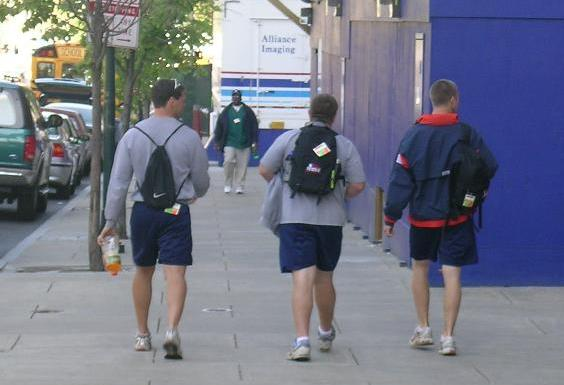

In [20]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

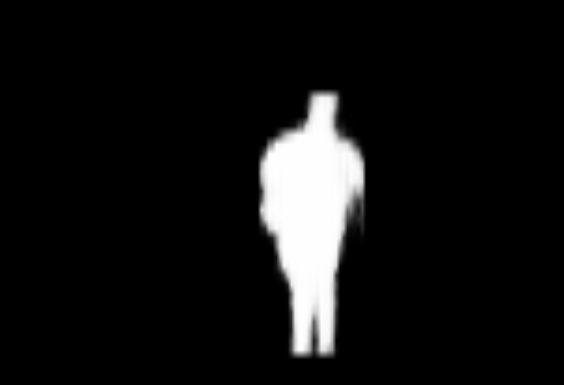

In [21]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [18]:
from pymatting import cutout

In [22]:
cutout(
   #img
   "in_image.png",
   #mask
   "mask_img.png",
   #output_img
   "out_img.png")

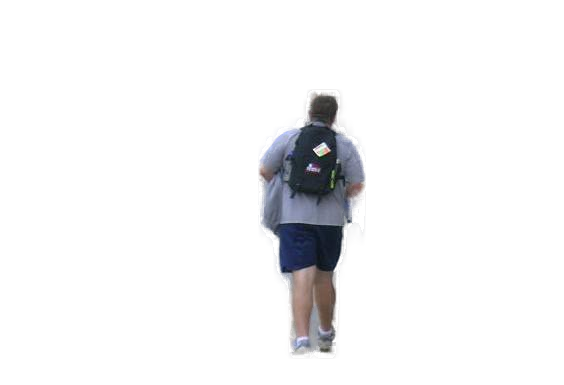

In [23]:
output_image = Image.open("out_img.png")
output_image